# Segmentation Project

In [1]:
import os, sys
import zipfile as zf

from skimage import color
from skimage import io
from skimage.io import imread
import cv2

from skimage.transform import resize
from scipy import ndimage
import numpy as np

import matplotlib.pyplot as plt
from IPython.display import clear_output

# U-NET
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
from torchsummary import summary
import torch.optim as optim
from time import time

from torch.nn import Linear, Conv2d, BatchNorm2d, MaxPool2d, Dropout2d

import time

import copy
import pickle


In [2]:
def TicTocGenerator():
    # Generator that returns time differences
    ti = 0           # initial time
    tf = time.time() # final time
    while True:
        ti = tf
        tf = time.time()
        yield tf-ti # returns the time difference

TicToc = TicTocGenerator() # create an instance of the TicTocGen generator

# This will be the main function through which we define both tic() and toc()
def toc(tempBool=True):
    # Prints the time difference yielded by generator instance TicToc
    tempTimeInterval = next(TicToc)
    return tempTimeInterval

def tic():
    # Records a time in TicToc, marks the beginning of a time interval
    toc(False)

In [3]:
# Check if device is available 
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
# Only run first time to unzip folder
current_path = os.getcwd()

files = zf.ZipFile("Dataset.zip", 'r')
files.extractall('Dataset_1')
files.close()

# Load dataset 

In [4]:
images_init = []
masks_init = []
size = (800, 800)

for root, dirs, files in os.walk('Dataset_1'):
    if root.endswith('images'):
        for file in files[0:]:
            images_init.append(imread(os.path.join(root, file)))

    if root.endswith('masks'):
        for file in files[0:]:
            mask = imread(os.path.join(root, file))
            mask = mask.astype('float64') 
            mask =  resize(mask, size, mode='constant', anti_aliasing=True)
            masks_init.append(mask)


# Only load of Test dataset

In [15]:
images_init = []
masks_init = []
size = (512, 512)

for root, dirs, files in os.walk('Dataset_1'):
    if root.endswith('images'):
        for file in files[145:]:
            images_init.append(imread(os.path.join(root, file)))

    if root.endswith('masks'):
        for file in files[145:]:
            mask = imread(os.path.join(root, file))
            mask = mask.astype('float64') 
            mask =  resize(mask, size, mode='constant', anti_aliasing=True)
            masks_init.append(mask)
            
images_1 = np.array([resize(x, size, mode='constant', anti_aliasing=True) for x in images_init], np.float32)
masks_1 = np.array([resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in masks_init], np.float32)

test = [145, 146, 147, 148, 149, 150, 151, 152, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164]

#test = [161, 162, 163, 164]

from torch.utils.data import DataLoader
batch_size = 19
data_test = DataLoader(list(zip(np.rollaxis(images_1, 3, 1), masks_1[:, np.newaxis])), batch_size=batch_size, shuffle=False)

TypeError: 'DataLoader' object is not subscriptable

# Prepare Test Data

In [5]:
images = [resize(x, size, mode='constant', anti_aliasing=True) for x in images_init]
masks = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in masks_init]

#ix = np.random.choice(len(images), len(images), False)

ix = range(len(images))
train, test = np.split(ix, [int(145)])
print('Training set: %d images, Testing set: %d images' %(len(train), len(test)))

Training set: 145 images, Testing set: 20 images


In [ ]:
size = (512,512)
images_1 = [resize(x, size, mode='constant', anti_aliasing=True) for x in images]
masks_1 = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in masks]
images_1 = np.array(images_1, np.float32)
masks_1 = np.array(masks_1, np.float32)

In [ ]:
test = [145, 146, 147, 148, 149, 150, 151, 152, 154, 155, 156, 157,
       158, 159, 160, 161, 162, 163, 164]

In [ ]:
from torch.utils.data import DataLoader
batch_size = 15
data_test = DataLoader(list(zip(np.rollaxis(images_1[test], 3, 1), masks_1[test, np.newaxis])), batch_size=batch_size, shuffle=True)

# Data Augmentation

In [6]:
images = np.array(images, np.float32)
masks = np.array(masks, np.float32)

In [ ]:
X_flip   = np.concatenate((np.flip(images[train], 2), images[train]))
Y_flip   = np.concatenate((np.flip(masks[train], 2), masks[train]))

X_flipud = np.concatenate((np.flipud(images[train]), images[train]))
Y_flipud = np.concatenate((np.flipud(masks[train]), masks[train]))

X_fliplr = np.concatenate((np.fliplr(images[train]), images[train]))
Y_fliplr = np.concatenate((np.fliplr(masks[train]), masks[train]))

X_1 = np.flip(np.concatenate((X_flipud, X_fliplr)))
Y_1 = np.flip(np.concatenate((Y_flipud, Y_fliplr)))
       
X_2 = np.flipud(np.concatenate((X_flip, X_fliplr)))
Y_2 = np.flipud(np.concatenate((Y_flip, Y_fliplr)))
       
X_3 = np.fliplr(np.concatenate((X_flip, X_flipud)))
Y_3 = np.fliplr(np.concatenate((Y_flip, Y_flipud)))
       
images = np.concatenate((images[train], X_flip))
images = np.concatenate((images, X_flipud))
images = np.concatenate((images, X_fliplr))
images = np.concatenate((images, X_1))
images = np.concatenate((images, X_2))
images = np.concatenate((images, X_3))
images = np.concatenate((images, images_sp))
       
masks = np.concatenate((masks[train], Y_flip))
masks = np.concatenate((masks, Y_flipud))
masks = np.concatenate((masks, Y_fliplr))
masks = np.concatenate((masks, Y_1))
masks = np.concatenate((masks, Y_2))
masks = np.concatenate((masks, Y_3))
masks = np.concatenate((masks, masks[train]))
       

In [7]:
X_flip   = np.concatenate((np.flip(images[train], 2), images[train]))
Y_flip   = np.concatenate((np.flip(masks[train], 2), masks[train]))

X_flipud = np.concatenate((np.flipud(images[train]), images[train]))
Y_flipud = np.concatenate((np.flipud(masks[train]), masks[train]))

X_fliplr = np.concatenate((np.fliplr(images[train]), images[train]))
Y_fliplr = np.concatenate((np.fliplr(masks[train]), masks[train]))

       
images = np.concatenate((images[train], X_flip))
images = np.concatenate((images, X_flipud))
images = np.concatenate((images, X_fliplr))

masks = np.concatenate((masks[train], Y_flip))
masks = np.concatenate((masks, Y_flipud))
masks = np.concatenate((masks, Y_fliplr))
       

In [8]:
X_aug = np.array(images, np.float32)
Y_aug = np.array(masks, np.float32)

# Random Crops
import random 
def randomCrop(img, mask, width, height):
    assert img.shape[1] >= height
    assert img.shape[2] >= width
    assert img.shape[1] == mask.shape[1]
    assert img.shape[2] == mask.shape[2]
    x = random.randint(1, img.shape[2] - width)
    y = random.randint(1, img.shape[1] - height)
    img = img[:, y:y+height, x:x+width]
    mask = mask[:, y:y+height, x:x+width]
    return img, mask

size = (512,512)

width = 600
height = 600
img_1, mask_1 = randomCrop(X_aug, Y_aug, width, height)

width = 700
height = 700
img_2, mask_2 = randomCrop(X_aug, Y_aug, width, height)

width = 750
height = 750
img_3, mask_3 = randomCrop(X_aug, Y_aug, width, height)

# Resize images
images = [resize(x, size, mode='constant', anti_aliasing=True) for x in X_aug]
masks = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in Y_aug]

images_crop1 = [resize(x, size, mode='constant', anti_aliasing=True) for x in img_1]
masks_crop1 = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in mask_1]

images_crop2 = [resize(x, size, mode='constant', anti_aliasing=True) for x in img_2]
masks_crop2 = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in mask_2]

images_crop3 = [resize(x, size, mode='constant', anti_aliasing=True) for x in img_3]
masks_crop3 = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in mask_3]

# Concatenate images
images = np.concatenate((images_crop1, images))
masks = np.concatenate((masks_crop1, masks))

images = np.concatenate((images_crop3, images))
masks = np.concatenate((masks_crop3, masks))

images = np.concatenate((images_crop3, images))
masks = np.concatenate((masks_crop3, masks))

print(images.shape)
print(masks.shape)

(4060, 512, 512, 3)
(4060, 512, 512)


# Brightsness and noise

In [ ]:
# Change image brightness
def increase_brightness(img, value):
    hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    h, s, v = cv2.split(hsv)

    lim = 255 - value
    v[v > lim] = 255
    v[v <= lim] += value

    final_hsv = cv2.merge((h, s, v))
    img = cv2.cvtColor(final_hsv, cv2.COLOR_HSV2BGR)
    return img

images_bright_1 = []
images_bright_2 = []
images_bright_3 = []
images_bright_4 = []
images_bright_5 = []
images_bright_6 = []

for i in range(len(train)):
    im = increase_brightness(images[i], 0.2)
    images_bright_1.append(im)
    im = increase_brightness(images[i], 0.3)
    images_bright_2.append(im)
    im = increase_brightness(images[i], 0.4)
    images_bright_3.append(im)
    im = increase_brightness(images[i], -0.2)
    images_bright_4.append(im)
    im = increase_brightness(images[i], -0.3)
    images_bright_5.append(im)
    im = increase_brightness(images[i], -0.4)
    images_bright_6.append(im)
    
images_bright_1 = np.array(images_bright_1, np.float32)
images_bright_2 = np.array(images_bright_2, np.float32)
images_bright_3 = np.array(images_bright_3, np.float32)
images_bright_4 = np.array(images_bright_4, np.float32)
images_bright_5 = np.array(images_bright_5, np.float32)
images_bright_6 = np.array(images_bright_6, np.float32)

# Add random noise
import random
from scipy import ndarray
import skimage as sk
from skimage import transform
from skimage import util

def random_noise(image_array: ndarray, mode: str, amount : float):
    # add random noise to the image
    return sk.util.random_noise(image_array)

images_sp = random_noise(images[train], 's&p', 1)
images_sp = np.array(images_sp, np.float32)

images = np.concatenate((images[train], images_bright_1))
masks = np.concatenate((masks[train], masks[train]))

images = np.concatenate((images, images_bright_2))
masks = np.concatenate((masks, masks[train]))

images = np.concatenate((images, images_bright_3))
masks = np.concatenate((masks, masks[train]))

images = np.concatenate((images, images_bright_4))
masks = np.concatenate((masks, masks[train]))

images = np.concatenate((images, images_bright_5))
masks = np.concatenate((masks, masks[train]))

images = np.concatenate((images, images_bright_6))
masks = np.concatenate((masks, masks[train]))

images = np.concatenate((images, images_sp))
masks = np.concatenate((masks, masks[train]))

# Size of Dataset after Augmentation

In [9]:
images = np.array(images, np.float32)
masks = np.array(masks, np.float32)

print('Loaded %d images' % len(images))

print('Size of images:', images.shape)
print('Size of masks', masks.shape)

Loaded 4060 images
Size of images: (4060, 512, 512, 3)
Size of masks (4060, 512, 512)


# Normalize images

In [ ]:
def normalize(d):
    # d is a (n x dimension) np array
    d -= np.min(d, axis=0)
    d /= np.ptp(d, axis=0)
    return d

images = normalize(images)

# Plot cells and corresponding masks 

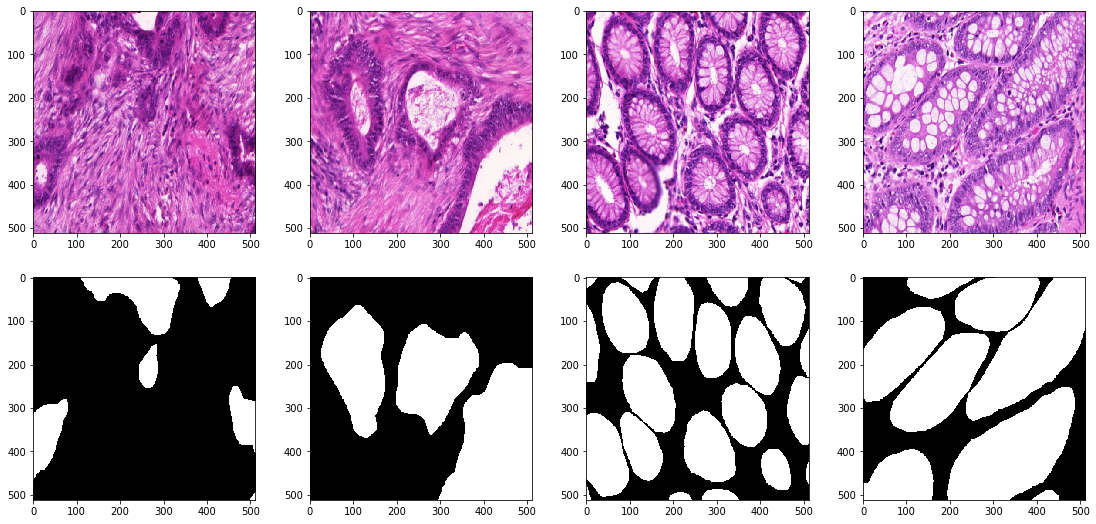

In [11]:
import matplotlib.pyplot as plt
from IPython.display import clear_output
plt.rcParams['figure.figsize'] = [19, 9]

idx = 180

for i in range(4):
    plt.subplot(2, 4, i+1)
    plt.imshow(images[i+idx])

    plt.subplot(2, 4, i+5)
    plt.imshow(masks[i+idx], cmap='gray')
plt.show();

# Split dataset in train and validation set

In [ ]:
ix = np.random.choice(len(images), len(images), False)
tr, val = np.split(ix, [int(len(images)*0.9)])
print('Training set: %d images, Validation set: %d images' %(len(tr), len(val)))

# Save Augmented Data

In [ ]:
from skimage.io import imsave

d = 0
for i in range(len(tr)):
    imsave('/home/s164201/Deep_Learning_Project/Aug/tr_im/train_im_%d.bmp'%d,images[tr[i]])
    imsave('/home/s164201/Deep_Learning_Project/Aug/tr_masks/train_mask_%d.bmp'%d,masks[tr[i]])
    d += 1
    
d = 0
for i in range(len(val)):
    imsave('/home/s164201/Deep_Learning_Project/Aug/val_im/val_im_%d.bmp'%d,images[val[i]])
    imsave('/home/s164201/Deep_Learning_Project/Aug/val_masks/val_mask_%d.bmp'%d,masks[val[i]])
    d += 1

# DataLoader

In [ ]:
# Dataloader
from torch.utils.data import DataLoader
batch_size = 5
data_tr = DataLoader(list(zip(np.rollaxis(images[tr], 3, 1), masks[tr, np.newaxis])), batch_size=batch_size, shuffle=True)
data_val = DataLoader(list(zip(np.rollaxis(images[val], 3, 1), masks[val, np.newaxis])), batch_size=batch_size, shuffle=True)

# DataLoader as you go (for larger images)

In [ ]:
from torch.utils.data import DataLoader

def load_dataset_tr():
    images_init_tr = []
    masks_init_tr = []
    
    size = (512, 512)

    for root, dirs, files in os.walk('Aug'):
        if root.endswith('tr_im'):
            for file in files[0:]:
                images_init_tr.append(imread(os.path.join(root, file)))
        if root.endswith('tr_masks'):
            for file in files[0:]:
                mask = imread(os.path.join(root, file))
                mask = mask.astype('float64') 
                mask =  resize(mask, size, mode='constant', anti_aliasing=True)
                masks_init_tr.append(mask)
            
    images_tr = [resize(x, size, mode='constant', anti_aliasing=True) for x in images_init_tr]
    masks_tr = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in masks_init_tr]

    images_tr = np.array(images_tr, np.float32)
    masks_tr = np.array(masks_tr, np.float32)
    
    data_tr = DataLoader(list(zip(np.rollaxis(images_tr, 3, 1), masks_tr[:,np.newaxis])), batch_size=5, shuffle=True)
    
    return data_tr


def load_dataset_val():
    images_init_val = []
    masks_init_val = []
    
    size = (512, 512)

    for root, dirs, files in os.walk('Aug'):
        if root.endswith('val_im'):
            for file in files[0:]:
                images_init_val.append(imread(os.path.join(root, file)))
        if root.endswith('val_masks'):
            for file in files[0:]:
                mask = imread(os.path.join(root, file))
                mask = mask.astype('float64') 
                mask =  resize(mask, size, mode='constant', anti_aliasing=True)
                masks_init_val.append(mask)
                

    images_val = [resize(x, size, mode='constant', anti_aliasing=True) for x in images_init_val]
    masks_val = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in masks_init_val]
    
    images_val = np.array(images_val, np.float32)
    masks_val = np.array(masks_val, np.float32)
    
    data_val = DataLoader(list(zip(np.rollaxis(images_val, 3, 1), masks_val[:, np.newaxis])), batch_size=5, shuffle=True)
    return data_val


# U-NET achitecture (256 x 256 images)

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0 = nn.Conv2d(3, 64, 3, padding=1)
        self.pool0 = nn.MaxPool2d(3, 2, padding=1)  # 256 -> 128
        self.enc_conv1 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool1 = nn.MaxPool2d(3, 2, padding=1)  # 128 -> 64
        self.enc_conv2 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool2 = nn.MaxPool2d(3, 2, padding=1)  # 64 -> 32
        self.enc_conv3 = nn.Conv2d(64, 64, 3, padding=1)
        self.pool3 = nn.MaxPool2d(3, 2, padding=1)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(64, 64, 3, padding=1)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(32)  # 16 -> 32
        self.dec_conv0 = nn.Conv2d(64*2, 64, 3, padding=1)
        self.upsample1 = nn.Upsample(64)  # 32 -> 64
        self.dec_conv1 = nn.Conv2d(64*2, 64, 3, padding=1)
        self.upsample2 = nn.Upsample(128)  # 64 -> 128
        self.dec_conv2 = nn.Conv2d(64*2, 64, 3, padding=1)
        self.upsample3 = nn.Upsample(256)  # 128 -> 256
        self.dec_conv3 = nn.Conv2d(64*2, 1, 3, padding=1)

    def forward(self, x):
        # encoder
        e0 = self.pool0(F.relu(self.enc_conv0(x)))
        e1 = self.pool1(F.relu(self.enc_conv1(e0)))
        e2 = self.pool2(F.relu(self.enc_conv2(e1)))
        e3 = self.pool3(F.relu(self.enc_conv3(e2)))

        # bottleneck
        b = F.relu(self.bottleneck_conv(e3))

        # decoder
        d0 = F.relu(self.dec_conv0(self.upsample0(torch.cat([b, e3], 1))))
        d1 = F.relu(self.dec_conv1(self.upsample1(torch.cat([d0, e2], 1))))
        d2 = F.relu(self.dec_conv2(self.upsample2(torch.cat([e1, d1], 1))))
        d3 = self.dec_conv3(self.upsample3(torch.cat([e0, d2], 1)))  # no activation
        return d3

# SegNET

In [ ]:
# (128x128)
interpolation = ['nearest', 'linear', 'bilinear', 'bicubic', 'trilinear']
inter = interpolation[2]

Kernel = 3
Pad = 1

F1 = 64
F2 = 128
F3 = 

class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0_1 = nn.Sequential(*[nn.Conv2d(1, 32, Kernel, padding=Pad), nn.BatchNorm2d(32)])
        self.pool0 = nn.MaxPool2d(3, 2, padding=1)  # 128 -> 64
        self.enc_conv1_1 = nn.Sequential(*[nn.Conv2d(32, 64, Kernel, padding=Pad), nn.BatchNorm2d(64)])
        self.enc_conv1_2 = nn.Sequential(*[nn.Conv2d(64, 64, Kernel, padding=Pad), nn.BatchNorm2d(64)])
        self.pool1 = nn.MaxPool2d(3, 2, padding=1)  # 64 -> 32
        self.enc_conv2_1 = nn.Sequential(*[nn.Conv2d(64, 128, Kernel, padding=Pad), nn.BatchNorm2d(128)])
        self.enc_conv2_2 = nn.Sequential(*[nn.Conv2d(128, 128, Kernel, padding=Pad), nn.BatchNorm2d(128)])
        self.pool2 = nn.MaxPool2d(3, 2, padding=1)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(128, 128, 5, padding=2)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(size=32, mode=inter)  # 16 -> 32
        self.dec_conv0_1 = nn.Sequential(*[nn.Conv2d(128, 128, Kernel, padding=Pad), nn.BatchNorm2d(128)])
        self.dec_conv0_2 = nn.Sequential(*[nn.Conv2d(128, 128, Kernel, padding=Pad), nn.BatchNorm2d(128)])
        self.upsample1 = nn.Upsample(size=64, mode=inter)  # 32 -> 64
        self.dec_conv1_1 = nn.Sequential(*[nn.Conv2d(128, 64, Kernel, padding=Pad), nn.BatchNorm2d(64)])
        self.dec_conv1_2 = nn.Sequential(*[nn.Conv2d(64, 64, Kernel, padding=Pad), nn.BatchNorm2d(64)])
        self.upsample2 = nn.Upsample(size=128, mode=inter)  # 64 -> 128
        self.dec_conv2_1 = nn.Conv2d(64, 1, Kernel, padding=Pad)
        
        self.dropout = Dropout2d(p=0.5)

    def forward(self, x):
        # encoder
        e0    = self.pool0(F.relu(self.enc_conv0_1(x)))
        xe2_1 = F.relu(self.enc_conv1_1(e0))
        e1    = self.pool1(F.relu(self.enc_conv1_2(xe2_1)))
        xe3_1 = F.relu(self.enc_conv2_1(e1))
        e2    = self.pool2(F.relu(self.enc_conv2_2(xe3_1)))
    
        # bottleneck
        b = F.relu(self.bottleneck_conv(e2))

        # decoder
        d0    = F.relu(self.dec_conv0_1(self.upsample0(b)))
        xd0_1 = F.relu(self.dec_conv0_2(d0))
        d1    = F.relu(self.dec_conv1_1(self.upsample1(xd0_1)))
        xd1_1 = F.relu(self.dec_conv1_2(d1))
        xd2_1 = F.relu(self.dec_conv2_1(self.upsample2(xd1_1)))

        return xd2_1

In [ ]:
# (128x128)
interpolation = ['nearest', 'linear', 'bilinear', 'bicubic', 'trilinear']
inter = interpolation[2]

Kernel = 3
Pad = 1

F1 = 32
F2 = 64
F3 = 128
F4 = 256


class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0_1 = nn.Sequential(*[nn.Conv2d(3, F1, Kernel, padding=Pad), nn.BatchNorm2d(F1)])
        self.enc_conv0_2 = nn.Sequential(*[nn.Conv2d(F1, F1, Kernel, padding=Pad), nn.BatchNorm2d(F1)])
        self.pool0 = nn.MaxPool2d(2, stride=2)  # 128 -> 64
        self.enc_conv1_1 = nn.Sequential(*[nn.Conv2d(F1, F2, Kernel, padding=Pad), nn.BatchNorm2d(F2)])
        self.enc_conv1_2 = nn.Sequential(*[nn.Conv2d(F2, F2, Kernel, padding=Pad), nn.BatchNorm2d(F2)])
        self.pool1 = nn.MaxPool2d(2, stride=2)  # 64 -> 32
        self.enc_conv2_1 = nn.Sequential(*[nn.Conv2d(F2, F3, Kernel, padding=Pad), nn.BatchNorm2d(F3)])
        self.enc_conv2_2 = nn.Sequential(*[nn.Conv2d(F3, F3, Kernel, padding=Pad), nn.BatchNorm2d(F3)])
        self.enc_conv2_3 = nn.Sequential(*[nn.Conv2d(F3, F3, Kernel, padding=Pad), nn.BatchNorm2d(F3)])
        self.pool2 = nn.MaxPool2d(2, stride=2) # 32 -> 16
        self.enc_conv3_1 = nn.Sequential(*[nn.Conv2d(F3, F4, Kernel, padding=Pad), nn.BatchNorm2d(F4)])
        self.enc_conv3_2 = nn.Sequential(*[nn.Conv2d(F4, F4, Kernel, padding=Pad), nn.BatchNorm2d(F4)])
        self.enc_conv3_3 = nn.Sequential(*[nn.Conv2d(F4, F4, Kernel, padding=Pad), nn.BatchNorm2d(F4)])
        self.pool3 = nn.MaxPool2d(2, stride=2)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(F4, F4, Kernel, padding=Pad)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(size=64, mode=inter)  # 16 -> 32
        self.dec_conv0_1 = nn.Sequential(*[nn.Conv2d(F4, F4, Kernel, padding=Pad), nn.BatchNorm2d(F4)])
        self.dec_conv0_2 = nn.Sequential(*[nn.Conv2d(F4, F4, Kernel, padding=Pad), nn.BatchNorm2d(F4)])
        self.dec_conv0_3 = nn.Sequential(*[nn.Conv2d(F4, F4, Kernel, padding=Pad), nn.BatchNorm2d(F4)])
        self.upsample1 = nn.Upsample(size=128, mode=inter) # 32 -> 64
        self.dec_conv1_1 = nn.Sequential(*[nn.Conv2d(F4, F3, Kernel, padding=Pad), nn.BatchNorm2d(F3)])
        self.dec_conv1_2 = nn.Sequential(*[nn.Conv2d(F3, F3, Kernel, padding=Pad), nn.BatchNorm2d(F3)])
        self.dec_conv1_3 = nn.Sequential(*[nn.Conv2d(F3, F3, Kernel, padding=Pad), nn.BatchNorm2d(F3)])
        self.upsample2 = nn.Upsample(size=256, mode=inter)  # 64 -> 128
        self.dec_conv2_1 = nn.Sequential(*[nn.Conv2d(F3, F2, Kernel, padding=Pad), nn.BatchNorm2d(F2)])
        self.dec_conv2_2 = nn.Sequential(*[nn.Conv2d(F2, F2, Kernel, padding=Pad), nn.BatchNorm2d(F2)])
        self.upsample3 = nn.Upsample(size=512, mode=inter)  # 64 -> 128
        self.dec_conv3_1 = nn.Sequential(*[nn.Conv2d(F2, F1, Kernel, padding=Pad), nn.BatchNorm2d(F1)])
        self.dec_conv3_2 = nn.Conv2d(F1, 1, Kernel, padding=Pad)
        
        self.dropout = Dropout2d(p=0.2)

    def forward(self, x):
        # encoder
        xe1_1 = F.relu(self.enc_conv0_1(x))
        e0    = self.pool0(F.relu(self.enc_conv0_2(xe1_1)))
        xe2_1 = F.relu(self.enc_conv1_1(e0))
        e1    = self.pool1(F.relu(self.enc_conv1_2(xe2_1)))
        xe3_1 = F.relu(self.enc_conv2_1(e1))
        xe3_2 = F.relu(self.enc_conv2_2(xe3_1))
        e2    = self.pool2(F.relu(self.enc_conv2_3(xe3_2)))
        drop1 = self.dropout(e2)
        xe4_1 = F.relu(self.enc_conv3_1(drop1))
        xe4_2 = F.relu(self.enc_conv3_2(xe4_1))
        e3    = self.pool3(F.relu(self.enc_conv3_3(xe4_2)))
        drop2 = self.dropout(e3)
    
        # bottleneck
        b = F.relu(self.bottleneck_conv(drop2))

        # decoder
        d0    = F.relu(self.dec_conv0_1(self.upsample0(b)))
        xd0_1 = F.relu(self.dec_conv0_2(d0))
        xd0_2 = F.relu(self.dec_conv0_3(xd0_1))
        drop3 = self.dropout(xd0_2)
        d1    = F.relu(self.dec_conv1_1(self.upsample1(drop3)))
        xd1_1 = F.relu(self.dec_conv1_2(d1))
        xd1_2 = F.relu(self.dec_conv1_3(xd1_1))
        drop4 = self.dropout(xd1_2)
        d2    = F.relu(self.dec_conv2_1(self.upsample2(drop4)))
        xd2_1 = F.relu(self.dec_conv2_2(d2))
        d3    = F.relu(self.dec_conv3_1(self.upsample3(xd2_1)))
        xd3_1 = F.relu(self.dec_conv3_2(d3))

        return xd3_1

In [ ]:
# (128x128)
interpolation = ['nearest', 'linear', 'bilinear', 'bicubic', 'trilinear']
inter = interpolation[2]

Kernel = 3
Pad = 1

F1 = 32
F2 = 64
F3 = 128
F4 = 256


class SegNet(nn.Module):
    def __init__(self):
        
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0_1 = nn.Sequential(*[nn.Conv2d(3, F1, Kernel, padding=Pad), nn.BatchNorm2d(F1)])
        self.enc_conv0_2 = nn.Sequential(*[nn.Conv2d(F1, F1, Kernel, padding=Pad), nn.BatchNorm2d(F1)])
        self.pool0 = nn.MaxPool2d(2, stride=2)  # 128 -> 64
        self.enc_conv1_1 = nn.Sequential(*[nn.Conv2d(F1, F2, Kernel, padding=Pad), nn.BatchNorm2d(F2)])
        self.enc_conv1_2 = nn.Sequential(*[nn.Conv2d(F2, F2, Kernel, padding=Pad), nn.BatchNorm2d(F2)])
        self.pool1 = nn.MaxPool2d(2, stride=2)  # 64 -> 32
        self.enc_conv2_1 = nn.Sequential(*[nn.Conv2d(F2, F3, Kernel, padding=Pad), nn.BatchNorm2d(F3)])
        self.enc_conv2_2 = nn.Sequential(*[nn.Conv2d(F3, F3, Kernel, padding=Pad), nn.BatchNorm2d(F3)])
        self.enc_conv2_3 = nn.Sequential(*[nn.Conv2d(F3, F3, Kernel, padding=Pad), nn.BatchNorm2d(F3)])
        self.pool2 = nn.MaxPool2d(2, stride=2)  # 32 -> 16
        self.enc_conv3_1 = nn.Sequential(*[nn.Conv2d(F3, F4, Kernel, padding=Pad), nn.BatchNorm2d(F4)])
        self.enc_conv3_2 = nn.Sequential(*[nn.Conv2d(F4, F4, Kernel, padding=Pad), nn.BatchNorm2d(F4)])
        self.enc_conv3_3 = nn.Sequential(*[nn.Conv2d(F4, F4, Kernel, padding=Pad), nn.BatchNorm2d(F4)])
        self.pool3 = nn.MaxPool2d(2, stride=2)  # 32 -> 16
        self.enc_conv4_1 = nn.Sequential(*[nn.Conv2d(F4, F5, Kernel, padding=Pad), nn.BatchNorm2d(F5)])
        self.enc_conv4_2 = nn.Sequential(*[nn.Conv2d(F5, F5, Kernel, padding=Pad), nn.BatchNorm2d(F5)])
        self.enc_conv4_3 = nn.Sequential(*[nn.Conv2d(F5, F5, Kernel, padding=Pad), nn.BatchNorm2d(F5)])
        self.pool4 = nn.MaxPool2d(2, stride=2)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(F5, F5, Kernel, padding=Pad)

        # decoder (upsampling)
        self.upsample00 = nn.Upsample(size=32, mode=inter)  # 64 -> 128
        self.dec_conv00_1 = nn.Sequential(*[nn.Conv2d(F5, F5, Kernel, padding=Pad), nn.BatchNorm2d(F5)])
        self.dec_conv00_2 = nn.Sequential(*[nn.Conv2d(F5, F5, Kernel, padding=Pad), nn.BatchNorm2d(F5)])
        self.dec_conv00_3 = nn.Sequential(*[nn.Conv2d(F5, F5, Kernel, padding=Pad), nn.BatchNorm2d(F5)])
        self.upsample0 = nn.Upsample(size=64, mode=inter)  # 16 -> 32
        self.dec_conv0_1 = nn.Sequential(*[nn.Conv2d(F5, F4, Kernel, padding=Pad), nn.BatchNorm2d(F4)])
        self.dec_conv0_2 = nn.Sequential(*[nn.Conv2d(F4, F4, Kernel, padding=Pad), nn.BatchNorm2d(F4)])
        self.dec_conv0_3 = nn.Sequential(*[nn.Conv2d(F4, F4, Kernel, padding=Pad), nn.BatchNorm2d(F4)])
        self.upsample1 = nn.Upsample(size=128, mode=inter)  # 32 -> 64
        self.dec_conv1_1 = nn.Sequential(*[nn.Conv2d(F4, F3, Kernel, padding=Pad), nn.BatchNorm2d(F3)])
        self.dec_conv1_2 = nn.Sequential(*[nn.Conv2d(F3, F3, Kernel, padding=Pad), nn.BatchNorm2d(F3)])
        self.dec_conv1_3 = nn.Sequential(*[nn.Conv2d(F3, F3, Kernel, padding=Pad), nn.BatchNorm2d(F3)])
        self.upsample2 = nn.Upsample(size=256, mode=inter)  # 64 -> 128
        self.dec_conv2_1 = nn.Sequential(*[nn.Conv2d(F3, F2, Kernel, padding=Pad), nn.BatchNorm2d(F2)])
        self.dec_conv2_2 = nn.Sequential(*[nn.Conv2d(F2, F2, Kernel, padding=Pad), nn.BatchNorm2d(F2)])
        self.upsample3 = nn.Upsample(size=512, mode=inter)  # 64 -> 128
        self.dec_conv3_1 = nn.Sequential(*[nn.Conv2d(F2, F1, Kernel, padding=Pad), nn.BatchNorm2d(F1)])
        self.dec_conv3_2 = nn.Conv2d(F1, 1, Kernel, padding=Pad)
        
        self.dropout = Dropout2d(p=0.2)

    def forward(self, x):
        # encoder
        xe1_1 = F.relu(self.enc_conv0_1(x))
        e0    = self.pool0(F.relu(self.enc_conv0_2(xe1_1)))
        xe2_1 = F.relu(self.enc_conv1_1(e0))
        e1    = self.pool1(F.relu(self.enc_conv1_2(xe2_1)))
        xe3_1 = F.relu(self.enc_conv2_1(e1))
        xe3_2 = F.relu(self.enc_conv2_2(xe3_1))
        e2    = self.pool2(F.relu(self.enc_conv2_3(xe3_2)))
        xe4_1 = F.relu(self.enc_conv3_1(e2))
        xe4_2 = F.relu(self.enc_conv3_2(xe4_1))
        e3    = self.pool3(F.relu(self.enc_conv3_3(xe4_2)))
        xe5_1 = F.relu(self.enc_conv4_1(e3))
        xe5_2 = F.relu(self.enc_conv4_2(xe5_1))
        e4    = self.pool4(F.relu(self.enc_conv4_3(xe5_2)))
    
        # bottleneck
        b = F.relu(self.bottleneck_conv(e4))

        # decoder
        d00    = F.relu(self.dec_conv00_1(self.upsample0(b)))
        xd00_1 = F.relu(self.dec_conv00_2(d00))
        xd00_2 = F.relu(self.dec_conv00_3(xd00_1))
        d0    = F.relu(self.dec_conv0_1(self.upsample0(xd00_2)))
        xd0_1 = F.relu(self.dec_conv0_2(d0))
        xd0_2 = F.relu(self.dec_conv0_3(xd0_1))
        d1    = F.relu(self.dec_conv1_1(self.upsample1(xd0_2)))
        xd1_1 = F.relu(self.dec_conv1_2(d1))
        xd1_2 = F.relu(self.dec_conv1_3(xd1_1))
        d2    = F.relu(self.dec_conv2_1(self.upsample2(xd1_2)))
        xd2_1 = F.relu(self.dec_conv2_2(d2))
        d3    = F.relu(self.dec_conv3_1(self.upsample3(xd2_1)))
        xd3_1 = F.relu(self.dec_conv3_2(d3))

        return xd3_1

In [ ]:
# (128x128)
interpolation = ['nearest', 'linear', 'bilinear', 'bicubic', 'trilinear']
inter = interpolation[2]

Kernel = 3
Pad = 1

F1 = 32
F2 = 64
F3 = 128
F4 = 256


class SegNet(nn.Module):
    def __init__(self):
        
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0_1 = nn.Sequential(*[nn.Conv2d(3, F1, Kernel, padding=Pad), nn.BatchNorm2d(F1)])
        self.enc_conv0_2 = nn.Sequential(*[nn.Conv2d(F1, F1, Kernel, padding=Pad), nn.BatchNorm2d(F1)])
        self.pool0 = nn.MaxPool2d(2, stride=2)  # 128 -> 64
        self.enc_conv1_1 = nn.Sequential(*[nn.Conv2d(F1, F2, Kernel, padding=Pad), nn.BatchNorm2d(F2)])
        self.enc_conv1_2 = nn.Sequential(*[nn.Conv2d(F2, F2, Kernel, padding=Pad), nn.BatchNorm2d(F2)])
        self.pool1 = nn.MaxPool2d(2, stride=2)  # 64 -> 32
        self.enc_conv2_1 = nn.Sequential(*[nn.Conv2d(F2, F3, Kernel, padding=Pad), nn.BatchNorm2d(F3)])
        self.enc_conv2_2 = nn.Sequential(*[nn.Conv2d(F3, F3, Kernel, padding=Pad), nn.BatchNorm2d(F3)])
        self.enc_conv2_3 = nn.Sequential(*[nn.Conv2d(F3, F3, Kernel, padding=Pad), nn.BatchNorm2d(F3)])
        self.pool2 = nn.MaxPool2d(2, stride=2)  # 32 -> 16
        self.enc_conv3_1 = nn.Sequential(*[nn.Conv2d(F3, F4, Kernel, padding=Pad), nn.BatchNorm2d(F4)])
        self.enc_conv3_2 = nn.Sequential(*[nn.Conv2d(F4, F4, Kernel, padding=Pad), nn.BatchNorm2d(F4)])
        self.enc_conv3_3 = nn.Sequential(*[nn.Conv2d(F4, F4, Kernel, padding=Pad), nn.BatchNorm2d(F4)])
        self.pool3 = nn.MaxPool2d(2, stride=2)  # 32 -> 16

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(F4, F4, Kernel, padding=Pad)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(size=64, mode=inter)  # 16 -> 32
        self.dec_conv0_1 = nn.Sequential(*[nn.Conv2d(F4, F4, Kernel, padding=Pad), nn.BatchNorm2d(F4)])
        self.dec_conv0_2 = nn.Sequential(*[nn.Conv2d(F4, F4, Kernel, padding=Pad), nn.BatchNorm2d(F4)])
        self.dec_conv0_3 = nn.Sequential(*[nn.Conv2d(F4, F4, Kernel, padding=Pad), nn.BatchNorm2d(F4)])
        self.upsample1 = nn.Upsample(size=128, mode=inter)  # 32 -> 64
        self.dec_conv1_1 = nn.Sequential(*[nn.Conv2d(F4, F3, Kernel, padding=Pad), nn.BatchNorm2d(F3)])
        self.dec_conv1_2 = nn.Sequential(*[nn.Conv2d(F3, F3, Kernel, padding=Pad), nn.BatchNorm2d(F3)])
        self.dec_conv1_3 = nn.Sequential(*[nn.Conv2d(F3, F3, Kernel, padding=Pad), nn.BatchNorm2d(F3)])
        self.upsample2 = nn.Upsample(size=256, mode=inter)  # 64 -> 128
        self.dec_conv2_1 = nn.Sequential(*[nn.Conv2d(F3, F2, Kernel, padding=Pad), nn.BatchNorm2d(F2)])
        self.dec_conv2_2 = nn.Sequential(*[nn.Conv2d(F2, F2, Kernel, padding=Pad), nn.BatchNorm2d(F2)])
        self.upsample3 = nn.Upsample(size=512, mode=inter)  # 64 -> 128
        self.dec_conv3_1 = nn.Sequential(*[nn.Conv2d(F2, F1, Kernel, padding=Pad), nn.BatchNorm2d(F1)])
        self.dec_conv3_2 = nn.Conv2d(F1, 1, Kernel, padding=Pad)
        
        self.dropout = Dropout2d(p=0.2)

    def forward(self, x):
        # encoder
        xe1_1 = F.relu(self.enc_conv0_1(x))
        e0    = self.pool0(F.relu(self.enc_conv0_2(xe1_1)))
        xe2_1 = F.relu(self.enc_conv1_1(e0))
        e1    = self.pool1(F.relu(self.enc_conv1_2(xe2_1)))
        xe3_1 = F.relu(self.enc_conv2_1(e1))
        xe3_2 = F.relu(self.enc_conv2_2(xe3_1))
        e2    = self.pool2(F.relu(self.enc_conv2_3(xe3_2)))
        xe4_1 = F.relu(self.enc_conv3_1(e2))
        xe4_2 = F.relu(self.enc_conv3_2(xe4_1))
        e3    = self.pool3(F.relu(self.enc_conv3_3(xe4_2)))
        drop2 = self.dropout(e3)
    
        # bottleneck
        b = F.relu(self.bottleneck_conv(drop2))

        # decoder
        d0    = F.relu(self.dec_conv0_1(self.upsample0(b)))
        xd0_1 = F.relu(self.dec_conv0_2(d0))
        xd0_2 = F.relu(self.dec_conv0_2(xd0_1))
        d1    = F.relu(self.dec_conv1_1(self.upsample1(xd0_2)))
        xd1_1 = F.relu(self.dec_conv1_2(d1))
        xd1_2 = F.relu(self.dec_conv1_3(xd1_1))
        d2    = F.relu(self.dec_conv2_1(self.upsample2(xd1_2)))
        xd2_1 = F.relu(self.dec_conv2_2(d2))
        d3    = F.relu(self.dec_conv3_1(self.upsample3(xd2_1)))
        xd3_1 = F.relu(self.dec_conv3_2(d3))

        return xd3_1

In [19]:
# (224x224)
interpolation = ['nearest', 'linear', 'bilinear', 'bicubic']
inter = interpolation[3]

Kernel = 3
Pad = 1

F1 = 32
F2 = 64
F3 = 128
F4 = 256
F5 = 256


class SegNet(nn.Module):
    def __init__(self):
        super().__init__()

        # encoder (downsampling)
        self.enc_conv0_1 = nn.Sequential(*[nn.Conv2d(3, F1, Kernel, padding=Pad), nn.BatchNorm2d(F1)])
        self.enc_conv0_2 = nn.Sequential(*[nn.Conv2d(F1, F1, Kernel, padding=Pad), nn.BatchNorm2d(F1)])
        self.pool0 = nn.MaxPool2d(2, stride=2)  # 224 -> 112
        self.enc_conv1_1 = nn.Sequential(*[nn.Conv2d(F1, F2, Kernel, padding=Pad), nn.BatchNorm2d(F2)])
        self.enc_conv1_2 = nn.Sequential(*[nn.Conv2d(F2, F2, Kernel, padding=Pad), nn.BatchNorm2d(F2)])
        self.pool1 = nn.MaxPool2d(2, stride=2)  # 112 -> 56
        self.enc_conv2_1 = nn.Sequential(*[nn.Conv2d(F2, F3, Kernel, padding=Pad), nn.BatchNorm2d(F3)])
        self.enc_conv2_2 = nn.Sequential(*[nn.Conv2d(F3, F3, Kernel, padding=Pad), nn.BatchNorm2d(F3)])
        self.enc_conv2_3 = nn.Sequential(*[nn.Conv2d(F3, F3, Kernel, padding=Pad), nn.BatchNorm2d(F3)])
        self.pool2 = nn.MaxPool2d(2, stride=2)  # 56 -> 28
        self.enc_conv3_1 = nn.Sequential(*[nn.Conv2d(F3, F4, Kernel, padding=Pad), nn.BatchNorm2d(F4)])
        self.enc_conv3_2 = nn.Sequential(*[nn.Conv2d(F4, F4, Kernel, padding=Pad), nn.BatchNorm2d(F4)])
        self.enc_conv3_3 = nn.Sequential(*[nn.Conv2d(F4, F4, Kernel, padding=Pad), nn.BatchNorm2d(F4)])
        self.pool3 = nn.MaxPool2d(2, stride=2)  # 28 -> 14
        self.enc_conv4_1 = nn.Sequential(*[nn.Conv2d(F4, F4, Kernel, padding=Pad), nn.BatchNorm2d(F4)])
        self.enc_conv4_2 = nn.Sequential(*[nn.Conv2d(F4, F4, Kernel, padding=Pad), nn.BatchNorm2d(F4)])
        self.enc_conv4_3 = nn.Sequential(*[nn.Conv2d(F4, F4, Kernel, padding=Pad), nn.BatchNorm2d(F4)])
        self.pool4 = nn.MaxPool2d(2, stride=2)  # 14 -> 7

        # bottleneck
        self.bottleneck_conv = nn.Conv2d(F4, F4, Kernel, padding=Pad)

        # decoder (upsampling)
        self.upsample0 = nn.Upsample(size=32, mode=inter)  # 7 -> 14
        self.dec_conv0_1 = nn.Sequential(*[nn.Conv2d(F4, F4, Kernel, padding=Pad), nn.BatchNorm2d(F4)])
        self.dec_conv0_2 = nn.Sequential(*[nn.Conv2d(F4, F4, Kernel, padding=Pad), nn.BatchNorm2d(F4)])
        self.dec_conv0_3 = nn.Sequential(*[nn.Conv2d(F4, F4, Kernel, padding=Pad), nn.BatchNorm2d(F4)])
        self.upsample1 = nn.Upsample(size=64, mode=inter)  # 14 -> 28
        self.dec_conv1_1 = nn.Sequential(*[nn.Conv2d(F4, F4, Kernel, padding=Pad), nn.BatchNorm2d(F4)])
        self.dec_conv1_2 = nn.Sequential(*[nn.Conv2d(F4, F4, Kernel, padding=Pad), nn.BatchNorm2d(F4)])
        self.dec_conv1_3 = nn.Sequential(*[nn.Conv2d(F4, F4, Kernel, padding=Pad), nn.BatchNorm2d(F4)])
        self.upsample2 = nn.Upsample(size=128, mode=inter)  # 28 -> 56
        self.dec_conv2_1 = nn.Sequential(*[nn.Conv2d(F4, F3, Kernel, padding=Pad), nn.BatchNorm2d(F3)])
        self.dec_conv2_2 = nn.Sequential(*[nn.Conv2d(F3, F3, Kernel, padding=Pad), nn.BatchNorm2d(F3)])
        self.dec_conv2_3 = nn.Sequential(*[nn.Conv2d(F3, F3, Kernel, padding=Pad), nn.BatchNorm2d(F3)])
        self.upsample3 = nn.Upsample(size=256, mode=inter)  # 56 -> 112
        self.dec_conv3_1 = nn.Sequential(*[nn.Conv2d(F3, F2, Kernel, padding=Pad), nn.BatchNorm2d(F2)])
        self.dec_conv3_2 = nn.Sequential(*[nn.Conv2d(F2, F2, Kernel, padding=Pad), nn.BatchNorm2d(F2)])
        self.upsample4 = nn.Upsample(size=512, mode=inter)  # 112 -> 224
        self.dec_conv4_1 = nn.Sequential(*[nn.Conv2d(F2, F1, Kernel, padding=Pad), nn.BatchNorm2d(F1)])
        self.dec_conv4_2 = nn.Conv2d(F1, 1, Kernel, padding=Pad)
        
        self.dropout = Dropout2d(p=0.2)

    def forward(self, x):
        # encoder
        xe1_1 = F.relu(self.enc_conv0_1(x))
        e0    = self.pool0(F.relu(self.enc_conv0_2(xe1_1)))
        xe2_1 = F.relu(self.enc_conv1_1(e0))
        e1    = self.pool1(F.relu(self.enc_conv1_2(xe2_1)))
        xe3_1 = F.relu(self.enc_conv2_1(e1))
        xe3_2 = F.relu(self.enc_conv2_2(xe3_1))
        e2    = self.pool2(F.relu(self.enc_conv2_3(xe3_2)))
        xe4_1 = F.relu(self.enc_conv3_1(e2))
        xe4_2 = F.relu(self.enc_conv3_2(xe4_1))
        e3    = self.pool3(F.relu(self.enc_conv3_3(xe4_2)))
        xe5_1 = F.relu(self.enc_conv4_1(e3))
        xe5_2 = F.relu(self.enc_conv4_2(xe5_1))
        e4    = self.pool4(F.relu(self.enc_conv4_3(xe5_2)))
    
        # bottleneck
        b = F.relu(self.bottleneck_conv(e4))

        # decoder
        d0    = F.relu(self.dec_conv0_1(self.upsample0(b)))
        xd0_1 = F.relu(self.dec_conv0_2(d0))
        xd0_2 = F.relu(self.dec_conv0_3(xd0_1))
        d1    = F.relu(self.dec_conv1_1(self.upsample1(xd0_2)))
        xd1_1 = F.relu(self.dec_conv1_2(d1))
        xd1_2 = F.relu(self.dec_conv1_3(xd1_1))
        d2    = F.relu(self.dec_conv2_1(self.upsample2(xd1_2)))
        xd2_1 = F.relu(self.dec_conv2_2(d2))
        xd2_2 = F.relu(self.dec_conv2_3(xd2_1))
        d3    = F.relu(self.dec_conv3_1(self.upsample3(xd2_2)))
        xd3_1 = F.relu(self.dec_conv3_2(d3))
        d4    = F.relu(self.dec_conv4_1(self.upsample4(xd3_1)))
        xd4_1 = F.relu(self.dec_conv4_2(d4))

        return xd4_1

# Binary Cross Entropy Loss Function

In [ ]:
criterion = torch.nn.BCEWithLogitsLoss().cuda()

# Training

In [ ]:
def train(model, optimizer, criterion, epochs, data_tr, data_val):
    X_val, Y_val = next(iter(data_val))
    #print(X_val.shape)
    #print(X_val.numpy().shape)
    Y_train = []
    Y_test = []
    AVG_LOSS = []
    AVG_LOSS_VAL = []
    TIME = []

    
    for epoch in range(epochs):
        tic()
        print('* Epoch %d/%d' % (epoch+1, epochs))

        avg_loss = 0
        avg_loss_val = 0
        
        model.train()  # train mode
        for X_batch, Y_batch in data_tr:
            X_batch = X_batch.to(device)
            Y_batch = Y_batch.to(device)
            X_batch = torch.autograd.Variable(X_batch)
            Y_batch = torch.autograd.Variable(Y_batch)
    
            # set parameter gradients to zero
            optimizer.zero_grad()

            # forward
            Y_pred = model(X_batch.to(device))

            loss = criterion(Y_pred, Y_batch)   # forward-pass
            loss.backward()  # backward-pass
            optimizer.step()  # update weights

            # calculate metrics to show the user
            avg_loss += loss / len(data_tr)
        Time = toc()
        
        AVG_LOSS.append(avg_loss)
        TIME.append(Time)

        # show intermediate results
        model.eval()  # testing mode
        for X_batch, Y_batch in data_val:
            Y_pred_val = model(X_batch.to(device))
            Y_pred_val = Y_pred_val.detach().cpu()
            loss_val = criterion(Y_pred_val, Y_batch)   # forward-pass
            avg_loss_val += loss_val / len(data_val)
       
        AVG_LOSS_VAL.append(avg_loss_val)
        
        Y_hat = model(X_val.to(device))
        Y_hat = Y_hat.detach().cpu()
        
        print('Training loss: %.4f. Validation loss: %.4f' %(avg_loss, loss_val))
        
        clear_output(wait=True)
        for k in range(4):
            plt.subplot(2, 4, k+1)
            #plt.imshow(np.rollaxis(X_val[k].numpy(), 0, 3))
            plt.imshow(Y_val[k, 0], cmap='gray')
            plt.title('Real', fontsize=20)
            plt.axis('off')
            
            plt.subplot(2, 4, k+5)
            plt.imshow(Y_hat[k, 0], cmap='gray')
            plt.title('Output', fontsize=20)
            plt.axis('off')

        plt.suptitle('%d / %d - Training loss: %.4f. Time per epoch: %.2f sec' % (epoch+1, epochs, avg_loss, Time), fontsize=25)
        plt.show()

    return Y_train, Y_test, AVG_LOSS, TIME, AVG_LOSS_VAL

# Summary model

In [20]:
model = SegNet()

if torch.cuda.device_count() > 1:
    print("Let's use", torch.cuda.device_count(), "GPUs!")
    # dim = 0 [30, xxx] -> [10, ...], [10, ...], [10, ...] on 3 GPUs
    model = nn.DataParallel(model)

model.to(device)
summary(model, (3, 512, 512))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 512, 512]             896
       BatchNorm2d-2         [-1, 32, 512, 512]              64
            Conv2d-3         [-1, 32, 512, 512]           9,248
       BatchNorm2d-4         [-1, 32, 512, 512]              64
         MaxPool2d-5         [-1, 32, 256, 256]               0
            Conv2d-6         [-1, 64, 256, 256]          18,496
       BatchNorm2d-7         [-1, 64, 256, 256]             128
            Conv2d-8         [-1, 64, 256, 256]          36,928
       BatchNorm2d-9         [-1, 64, 256, 256]             128
        MaxPool2d-10         [-1, 64, 128, 128]               0
           Conv2d-11        [-1, 128, 128, 128]          73,856
      BatchNorm2d-12        [-1, 128, 128, 128]             256
           Conv2d-13        [-1, 128, 128, 128]         147,584
      BatchNorm2d-14        [-1, 128, 1

/home/s164201/.conda/envs/py3/lib/python3.7/site-packages/torch/nn/functional.py:2539: UserWarning: Default upsampling behavior when mode=bicubic is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode))


# Training Network

In [ ]:
# SGD
N_epochs = 10
Learning_Rate = 0.01
# weight_decay=0.01
optimizer = optim.SGD(model.parameters(), Learning_Rate, momentum=0.9)

Y_train, Y_test, avg_loss, Time, avg_loss_val = train(model, optimizer, criterion, N_epochs, load_dataset_tr(), load_dataset_val())


In [ ]:
# SGD
epochs = 50
Learning_Rate = 0.005
optimizer = optim.SGD(model.parameters(), Learning_Rate, momentum=0.9)

Y_train = []
Y_test = []

for epoch in range(epochs):
    print('* Epoch %d/%d' % (epoch+1, epochs))

    avg_loss = 0
    avg_loss_val = 0

    model.train()  # train mode
    for batch_idx, (X_batch, Y_batch) in enumerate(load_dataset_tr()):
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        X_batch = torch.autograd.Variable(X_batch)
        Y_batch = torch.autograd.Variable(Y_batch)

        # set parameter gradients to zero
        optimizer.zero_grad()

        # forward
        Y_pred = model(X_batch.to(device))

        loss = criterion(Y_pred, Y_batch)   # forward-pass
        loss.backward()  # backward-pass
        optimizer.step()  # update weights

        # calculate metrics to show the user
        avg_loss += loss / len(X_batch)
        
    # show intermediate results
    model.eval()  # testing mode
    for batch_idx, (X_batch, Y_batch) in enumerate(load_dataset_val()):
        Y_pred_val = model(X_batch.to(device))
        Y_pred_val = Y_pred_val.detach().cpu()
        loss_val = criterion(Y_pred_val, Y_batch)   # forward-pass
        avg_loss_val += loss_val / len(X_batch)

    print('Training loss: %.4f. Validation loss: %.4f' %(avg_loss, loss_val))


# Save model

In [ ]:
saved_model = copy.deepcopy(model)
with open(r"Segnet_model_final.pkl", "wb") as output_file:
    pickle.dump(saved_model, output_file)

# Load model

In [ ]:
model = pickle.load( open( "Segnet_model_final.pkl", "rb" ) )

# Plot of loss

In [ ]:
N_epochs = 10
plt.figure(figsize=(9,5))
x_axis = range(1,N_epochs+1)
plt.plot(x_axis,avg_loss,'g-')
plt.plot(x_axis,avg_loss_val,'r-')

plt.title('Binary Cross Entropy loss', size=15)
plt.legend(('Training loss', 'Validation loss'), loc='upper right', prop={'size': 12})
plt.xlabel('Epochs', size=12)
plt.ylabel('Average loss', size=12)
plt.show()

print("Training loss: %.4f" %(avg_loss[-1]))
print("Validation loss: %.4f" %(avg_loss_val[-1]))


# Prediction

In [ ]:
def predict(model, data):
    model.eval()  # testing mode
    Y_out = model(X_test.to(device)).detach().cpu()
    Y_pred = np.array(Y_out > 0)
    return Y_pred, Y_out

X_test, Y_test = next(iter(data_test))

Y_pred, Y_out = predict(model, X_test)

In [ ]:
# Plot of predictions
k = 3
plt.figure(figsize=(19,5))
plt.subplot(1, 4, 1)
plt.imshow(np.rollaxis(X_test[k].numpy(), 0, 3))
#plt.imshow(X_val[k,0].numpy(), cmap='gray')
plt.title('Ground truth image', fontsize=17)
plt.axis('off')

plt.subplot(1, 4, 2)
plt.imshow(Y_test[k][0][:][:], cmap='gray')
plt.title('Ground truth segmentation', fontsize=17)
plt.axis('off')

plt.subplot(1, 4, 3)
plt.imshow(Y_out[k, 0], cmap='gray')
plt.title('Model output', fontsize=17)
plt.axis('off')

plt.subplot(1, 4, 4)
plt.imshow(Y_pred[k, 0], cmap='gray')
plt.title('Prediction > 0', fontsize=17)
plt.axis('off')


# Intersection over union (f1 score)

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
f1 = 0

for i in range(len(Y_pred)):
    f1 += f1_score(Y_test[i].reshape(-1), Y_pred[i].reshape(-1), average='macro')
    print("%.4f" %(f1_score(Y_test[i].reshape(-1), Y_pred[i].reshape(-1), average='macro')))
    

f1 /= len(Y_pred)

print()
print("f1 score = %.2f%%" %(f1*100))
#print("Time per epoch = %.2f" %(sum(Time)/N_epochs))
